PROJECT KLASIFIKASI GAMBAR CAT AND DOG [MODEL

**1. LOAD DATASET**

In [5]:
!kaggle datasets download -d tongpython/cat-and-dog -p /content/ --force

Dataset URL: https://www.kaggle.com/datasets/tongpython/cat-and-dog
License(s): CC0-1.0
 90% 197M/218M [00:00<00:00, 320MB/s]
100% 218M/218M [00:00<00:00, 329MB/s]


In [6]:
import zipfile
zip_path = '/content/cat-and-dog.zip'
extract_to = '/content/data/'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

In [7]:
import os
import shutil

def copy_tree(src_dir, dest_dir):
    """ Salin semua file dan folder dari src_dir ke dest_dir """
    if not os.path.exists(dest_dir):
        os.makedirs(dest_dir)

    for item in os.listdir(src_dir):
        s = os.path.join(src_dir, item)
        d = os.path.join(dest_dir, item)
        if os.path.isdir(s):
            # Jika item adalah folder, salin folder dan isinya
            shutil.copytree(s, d, dirs_exist_ok=True)
        else:
            # Jika item adalah file, salin file
            shutil.copy2(s, d)

# Path ke folder
train_dir = '/content/data/training_set/training_set'
test_dir = '/content/data/test_set/test_set'
dataset_dir = '/content/data/datasets'

# Salin folder dari training_set dan test_set ke datasets
copy_tree(train_dir, dataset_dir)
copy_tree(test_dir, dataset_dir)

print("Penggabungan selesai!")


Penggabungan selesai!


In [8]:
import os
import shutil
from pathlib import Path
import pandas as pd
dataset = "/content/data/datasets"
directory_path = Path(dataset)
filepaths_png = list(directory_path.glob(r'**/*.png'))
filepaths_jpeg = list(directory_path.glob(r'**/*.jpg')) + list(directory_path.glob(r'**/*.jpeg'))
filepaths = filepaths_png + filepaths_jpeg
labels = [os.path.split(os.path.split(x)[0])[1] for x in filepaths]
filepaths = pd.DataFrame(filepaths, columns=['Filepath']).astype(str)
labels = pd.DataFrame(labels, columns=['Label'])
image_df = pd.concat([filepaths, labels], axis=1)
image_df = image_df.sample(frac=1).reset_index(drop=True)
image_df = pd.concat([filepaths, labels], axis=1)
image_df = image_df.sample(frac=1).reset_index(drop=True)
image_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10028 entries, 0 to 10027
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Filepath  10028 non-null  object
 1   Label     10028 non-null  object
dtypes: object(2)
memory usage: 156.8+ KB


**Validasi class**

In [9]:
import os

def list_folders_in_directory(directory):
    folders = [name for name in os.listdir(directory) if os.path.isdir(os.path.join(directory, name))]
    return sorted(folders)

print(list_folders_in_directory(dataset))

['cats', 'dogs']


**VISUALISASI SAMPLE GAMBAR (PLOT)**

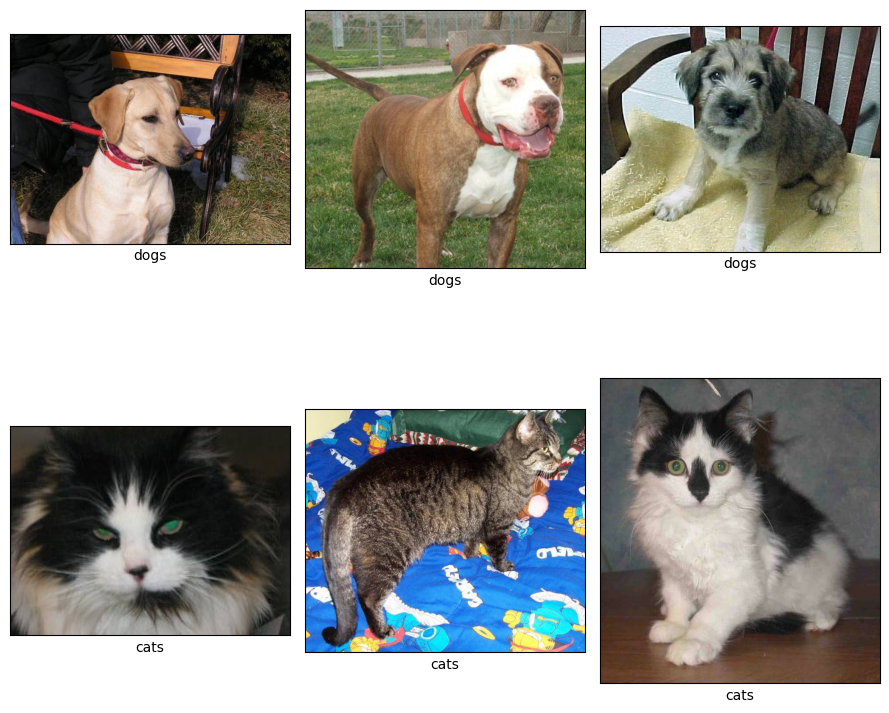

In [10]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
dataset_img = {}

for class_name in os.listdir(directory_path):
    dataset_img[class_name] = os.listdir(os.path.join(directory_path, class_name))

random_classes = np.random.choice(list(dataset_img.keys()), 2, replace=False)

fig, axs = plt.subplots(len(random_classes), 3, figsize=(9, 9))

for i, class_name in enumerate(random_classes):
    images = np.random.choice(dataset_img[class_name], 3, replace=False)

    for j, image_name in enumerate(images):
        img_path = os.path.join(directory_path, class_name, image_name)
        img = Image.open(img_path)
        axs[i, j].imshow(img)
        axs[i, j].set(xlabel=class_name, xticks=[], yticks=[])
        img.close()

fig.tight_layout()
plt.show()

In [ ]:
file_name = []
labels = []
full_path = []

for path, subdirs, files in os.walk(directory_path):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

distribution_data = pd.DataFrame({
    "path": full_path,
    'file_name': file_name,
    "labels": labels
})

distribution_data['labels'] = distribution_data['labels'].astype('category')

# menampilkan sampel data distribution_data
distribution_data.sample(5)

,path,file_name,labels
5243,/content/data/datasets/cats/cat.2250.jpg,cat.2250.jpg,cats
2725,/content/data/datasets/dogs/dog.4877.jpg,dog.4877.jpg,dogs
6920,/content/data/datasets/cats/cat.3734.jpg,cat.3734.jpg,cats
8776,/content/data/datasets/cats/cat.1967.jpg,cat.1967.jpg,cats
1435,/content/data/datasets/dogs/dog.2947.jpg,dog.2947.jpg,dogs


**SPLIT DATA UNTUK MEMBUAT MODEL**

**Dataset Dibagi Menjadi 80% Train Set dan 20% Test Set**

In [ ]:
import sklearn.model_selection
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(
    distribution_data, test_size=0.2, shuffle=True, random_state=1, stratify=distribution_data['labels'])
train_df = train_df.rename(columns={'path': 'Filepath', 'labels': 'Label'})
test_df = test_df.rename(columns={'path': 'Filepath', 'labels': 'Label'})

#menamipilkan data


**GENERATE IMAGE**

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    rotation_range=40,
    zoom_range=0.2,
    brightness_range=[0.8, 1.2]
)

# Hanya rescale untuk validation set (tidak perlu augmentasi)
validation_datagen = ImageDataGenerator(rescale=1.0/255)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=None,
    x_col='Filepath',
    y_col='Label',
    target_size=(150, 150),
    batch_size=32,
    color_mode='rgb',
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=None,
    x_col='Filepath',
    y_col='Label',
    target_size=(150, 150),
    batch_size=32,
    color_mode='rgb',
    class_mode='categorical',
    shuffle=True,
    seed=42,
)

Found 8022 validated image filenames belonging to 2 classes.
Found 2006 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 2 invalid image filename(s) in x_col="Filepath". These filename(s) will be ignored.
  warnings.warn(


# **MODEL**

**Model Menggunakan Model Sequential, Conv2D, Pooling Layer**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.5))

model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))

num_classes = len(train_generator.class_indices)  # Jumlah kelas
model.add(Dense(num_classes, activation='softmax'))

model.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 15, 15, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 7, 7, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 7, 7, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       6,423,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │           1,026 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,812,482 (25.99 MB)

 Trainable params: 6,812,482 (25.99 MB)

 Non-trainable params: 0 (0.00 B)

**MENGIMPLETASIKAN CALLBACK**

In [ ]:
from keras.callbacks import Callback
class AccuracyBasedEarlyStopping(Callback):
    def __init__(self, monitor='val_accuracy', target_accuracy=0.85, patience=3, verbose=0):
        super(AccuracyBasedEarlyStopping, self).__init__()
        self.monitor = monitor
        self.target_accuracy = target_accuracy
        self.patience = patience
        self.verbose = verbose
        self.wait = 0
        self.best = 0
        self.stopped_epoch = 0

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        val_accuracy = logs.get(self.monitor)
        if val_accuracy is not None:
            if val_accuracy >= self.target_accuracy:
                if self.verbose > 0:
                    print(f"\nEpoch {epoch + 1}: {self.monitor} has reached target of {self.target_accuracy:.2f}. Stopping training.")
                self.model.stop_training = True
        else:
            if self.verbose > 0:
                print(f"\nEpoch {epoch + 1}: {self.monitor} not available. Continuing training.")

In [ ]:
early_stop = AccuracyBasedEarlyStopping(monitor='val_accuracy', target_accuracy=0.90, patience=5, verbose=1)

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
lr_scheduler = ReduceLROnPlateau(factor=0.5, patience=5, min_lr=0.000001, monitor='val_loss')

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss'),

**# TRAINING MODEL**

In [ ]:
import time
start_time = time.time()

history = model.fit(
    train_generator,
    epochs=55,
    batch_size=32,
    validation_data=validation_generator,
    callbacks=[checkpoint, early_stop, lr_scheduler]
)

execution_time = time.time() - start_time
print(f"Execution time: {execution_time:.2f} seconds")

Epoch 1/55


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


251/251 ━━━━━━━━━━━━━━━━━━━━ 87s 306ms/step - accuracy: 0.4906 - loss: 0.7052 - val_accuracy: 0.5050 - val_loss: 0.6930 - learning_rate: 0.0010
Epoch 2/55
251/251 ━━━━━━━━━━━━━━━━━━━━ 61s 235ms/step - accuracy: 0.5048 - loss: 0.6940 - val_accuracy: 0.5025 - val_loss: 0.6931 - learning_rate: 0.0010
Epoch 3/55
251/251 ━━━━━━━━━━━━━━━━━━━━ 61s 238ms/step - accuracy: 0.4912 - loss: 0.6936 - val_accuracy: 0.4995 - val_loss: 0.6932 - learning_rate: 0.0010
Epoch 4/55
251/251 ━━━━━━━━━━━━━━━━━━━━ 82s 237ms/step - accuracy: 0.5039 - loss: 0.6925 - val_accuracy: 0.5359 - val_loss: 0.6895 - learning_rate: 0.0010
Epoch 5/55
251/251 ━━━━━━━━━━━━━━━━━━━━ 82s 239ms/step - accuracy: 0.5440 - loss: 0.6874 - val_accuracy: 0.5528 - val_loss: 0.6844 - learning_rate: 0.0010
Epoch 6/55
251/251 ━━━━━━━━━━━━━━━━━━━━ 82s 235ms/step - accuracy: 0.5623 - loss: 0.6839 - val_accuracy: 0.5304 - val_loss: 0.6885 - learning_rate: 0.0010
Epoch 7/55
251/251 ━━━━━━━━━━━━━━━━━━━━ 84s 245ms/step - accuracy: 0.5602 - loss:

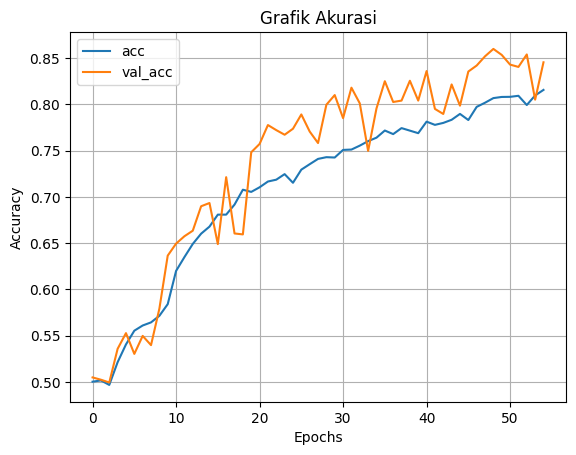

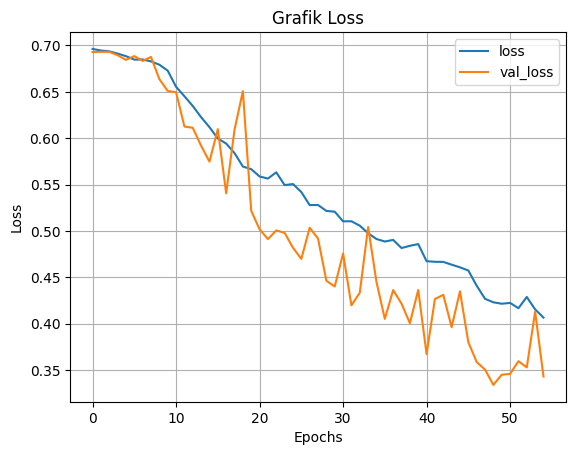

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.title('Grafik Akurasi')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Grafik Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step
Confusion Matrix
Normalized confusion matrix
Classification Report
              precision    recall  f1-score   support

        cats       0.50      0.44      0.47      1002
        dogs       0.50      0.56      0.53      1004

    accuracy                           0.50      2006
   macro avg       0.50      0.50      0.50      2006
weighted avg       0.50      0.50      0.50      2006



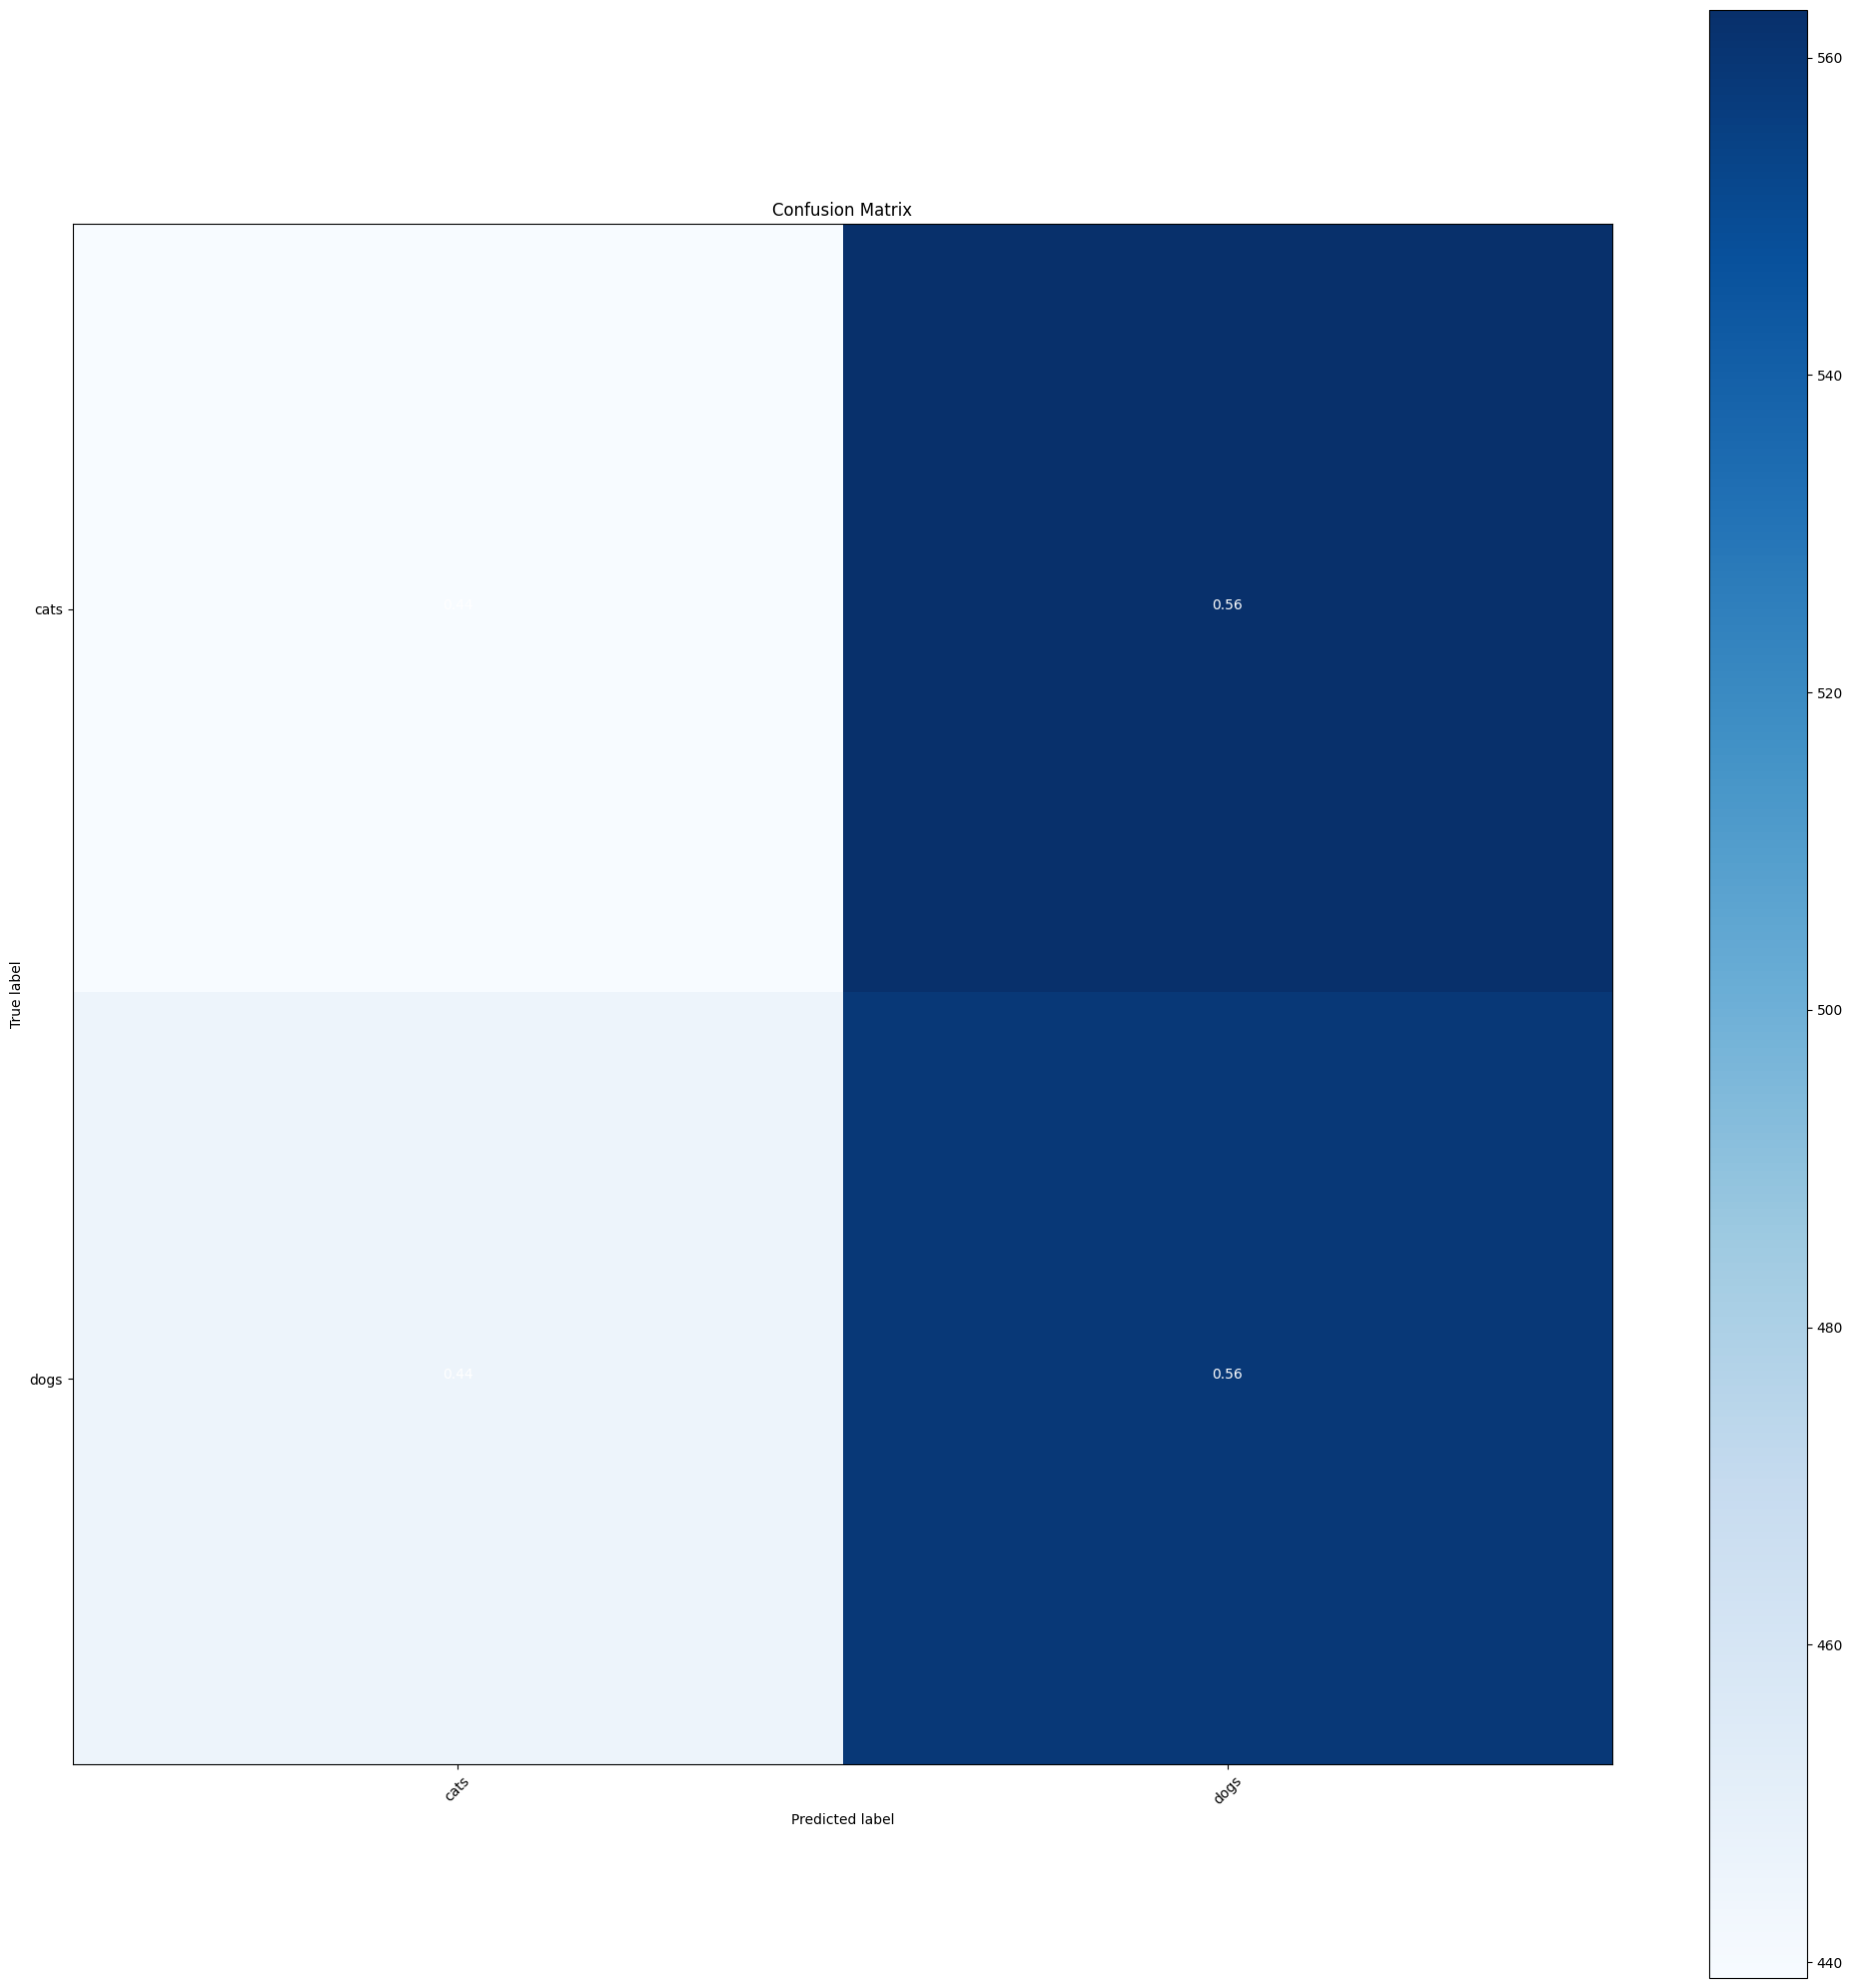

In [ ]:
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap='Blues'):
    plt.figure(figsize=(20, 20))

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('confusion_matrix.png')

target_names = []
for key in train_generator.class_indices:
    target_names.append(key)

Y_pred = model.predict(validation_generator)
y_pred = np.argmax(Y_pred, axis=1)

print('Confusion Matrix')
cm = confusion_matrix(validation_generator.classes, y_pred)
plot_confusion_matrix(cm, target_names, title='Confusion Matrix')

print('Classification Report')
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

In [ ]:
test_results = model.evaluate(train_generator, verbose=0)
train_results = model.evaluate(validation_generator, verbose=0)

print("Train Loss: {:.5f}".format(train_results[0]))
print("Train Accuracy: {:.2f}%".format(train_results[1] * 100))
print("Test Loss: {:.5f}".format(test_results[0]))
print("Test Accuracy: {:.2f}%".format(test_results[1] * 100))


Train Loss: 0.34311
Train Accuracy: 84.55%
Test Loss: 0.37624
Test Accuracy: 83.48%


In [ ]:
saved_model_dir = '/content/SavedModel'
model.export(saved_model_dir)

Saved artifact at '/content/SavedModel'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  138352299275472: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138352299276048: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138352297330640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138352297331792: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138352297333328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138352297333904: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138352297333712: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138352297334864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138352297333136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138352297335824: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13835229733

In [ ]:
!pip install tensorflow # install tensorflow
import tensorflow as tf

saved_model_dir = '/content/SavedModel'

converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)

tflite_model = converter.convert()

tflite_model_name = '/content/TFLite.tflite'
with open(tflite_model_name, 'wb') as f:
    f.write(tflite_model)

In [ ]:
!pip install tensorflowjs
saved_model_dir = '/content/SavedModel'
tfjs_model_dir = '/content/TFJS'

!tensorflowjs_converter --input_format=tf_saved_model \
                        --output_format=tfjs_graph_model \
                        "{saved_model_dir}" \
                        "{tfjs_model_dir}"

INFO: pip is looking at multiple versions of tf-keras to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 102.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.4/615.4 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 65.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 76.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 80.7 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.17.1
    Uninstalling tensorboard-2.17.1:
      Successfully uni

2025-01-19 06:21:54.724070: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1737267714.747213   33781 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1737267714.757551   33781 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
2025-01-19 06:21:58.392694: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
I0000 00:00:1737267718.392882   33781 gpu_device.cc:2022] Created device /job:localhost/replica:0/task

In [ ]:
!pip freeze > requirements.txt
!zip -r /content/SavedModel.zip /content/SavedModel
!zip -r /content/TFJS.zip /content/TFJS
from google.colab import files

  adding: content/SavedModel/ (stored 0%)
  adding: content/SavedModel/variables/ (stored 0%)
  adding: content/SavedModel/variables/variables.index (deflated 64%)
  adding: content/SavedModel/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: content/SavedModel/fingerprint.pb (stored 0%)
  adding: content/SavedModel/saved_model.pb (deflated 85%)
  adding: content/SavedModel/assets/ (stored 0%)
  adding: content/TFJS/ (stored 0%)
  adding: content/TFJS/group1-shard5of7.bin (deflated 7%)
  adding: content/TFJS/group1-shard4of7.bin (deflated 7%)
  adding: content/TFJS/group1-shard1of7.bin (deflated 7%)
  adding: content/TFJS/group1-shard6of7.bin (deflated 7%)
  adding: content/TFJS/group1-shard7of7.bin (deflated 7%)
  adding: content/TFJS/group1-shard2of7.bin (deflated 7%)
  adding: content/TFJS/group1-shard3of7.bin (deflated 7%)
  adding: content/TFJS/model.json (deflated 90%)


In [ ]:
files.download('/content/SavedModel.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>